In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats import proportion

## Load the Titanic data and get a sense of what kind of information we have
titanic_df = pd.read_csv('titanic-data.csv', index_col='PassengerId')
print titanic_df.iloc[:10,:]

             Survived  Pclass  \
PassengerId                     
1                   0       3   
2                   1       1   
3                   1       3   
4                   1       1   
5                   0       3   
6                   0       3   
7                   0       1   
8                   0       3   
9                   1       3   
10                  1       2   

                                                          Name     Sex   Age  \
PassengerId                                                                    
1                                      Braund, Mr. Owen Harris    male  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
3                                       Heikkinen, Miss. Laina  female  26.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
5                                     Allen, Mr. William Henry    male  35.0   
6                                          

Here are some questions that come to mind:

* What were the rates of survival for 
  * men vs. women?
  * among the three classes?
  * children vs. adults?
  * people traveling alone vs. with family?
* How were the fares determined?

In [51]:
## Look for missing values
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


Several of the columns have missing values. For age, I'm going to group the passengers by age group (child, adult, and senior), so I will assign a fourth category, unknown, to those with missing age values. For the two missing values in the Embarked, I'll do a similar thing - create a new column with more descriptive values, and categorize the missing values as unknown. Most of the passengers do not have cabin information, but I don't think I will use that column anyway, so I'll leave that alone.

In [52]:
## Add a categorical age group column
def age_category(age):
    if pd.isnull(age):
        return 'unknown'
    elif age < 18:
        return 'child'
    elif age < 60:
        return 'adult'
    else:
        return 'senior'
    
titanic_df['AgeGroup'] = titanic_df['Age'].apply(age_category)
print titanic_df.iloc[:20][['Age', 'AgeGroup']]    ## make sure it worked

              Age AgeGroup
PassengerId               
1            22.0    adult
2            38.0    adult
3            26.0    adult
4            35.0    adult
5            35.0    adult
6             NaN  unknown
7            54.0    adult
8             2.0    child
9            27.0    adult
10           14.0    child
11            4.0    child
12           58.0    adult
13           20.0    adult
14           39.0    adult
15           14.0    child
16           55.0    adult
17            2.0    child
18            NaN  unknown
19           31.0    adult
20            NaN  unknown


In [53]:
## Add a column with full names of embarkation sites
titanic_df['Port'] = titanic_df['Embarked'].map({'C' : 'Cherbourg', 'Q' : 'Queenstown', 'S' : 'Southampton', np.nan : 'Unknown'})
print titanic_df.iloc[:20][['Embarked', 'Port']]   ## make sure it worked

            Embarked         Port
PassengerId                      
1                  S  Southampton
2                  C    Cherbourg
3                  S  Southampton
4                  S  Southampton
5                  S  Southampton
6                  Q   Queenstown
7                  S  Southampton
8                  S  Southampton
9                  S  Southampton
10                 C    Cherbourg
11                 S  Southampton
12                 S  Southampton
13                 S  Southampton
14                 S  Southampton
15                 S  Southampton
16                 S  Southampton
17                 Q   Queenstown
18                 S  Southampton
19                 S  Southampton
20                 C    Cherbourg


Overall survival rate:  0.383838383838
Survival rate by gender:  Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64
Populating the interactive namespace from numpy and matplotlib


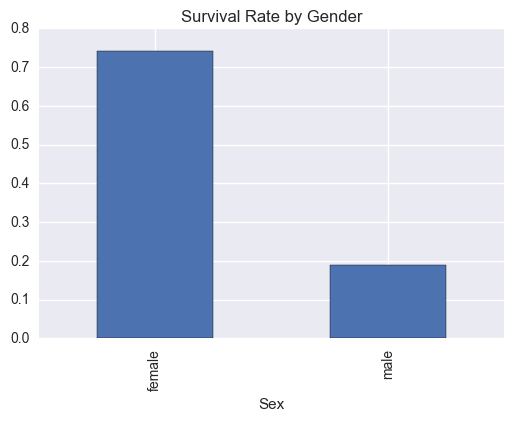

In [54]:
## Get some descriptive statistics
overall_survival = titanic_df['Survived']
print 'Overall survival rate: ', overall_survival.mean()

gender_survival = titanic_df.groupby('Sex')['Survived']
print 'Survival rate by gender: ', gender_survival.mean()

%pylab inline
gender_survival.mean().plot(kind='bar')
plt.title('Survival Rate by Gender')

Survival rate by class:  Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64


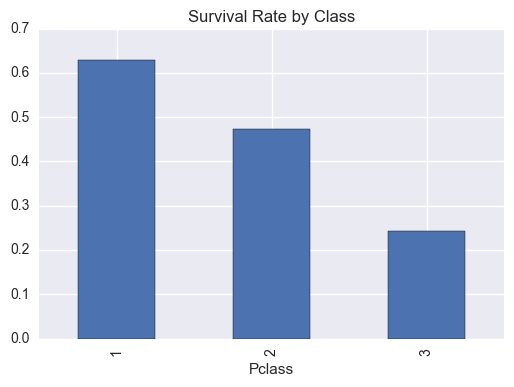

In [55]:
class_survival = titanic_df.groupby('Pclass')['Survived']
print 'Survival rate by class: ', class_survival.mean()

class_survival.mean().plot(kind='bar')
plt.title('Survival Rate by Class')

I found the overall survival rate as a point of comparison: 38.38%.

For men, the survival rate was 18.89% and for women, it was 74.20%.

And when broken down by class, 1st class had a 62.96% survival rate, 2nd class had 47.28%, and 3rd class had 24.24%.

These appear to be significantly different, but we can confirm this with statistical tests.

In [56]:
## independent t-test to compare survival means for male and female passengers

female = titanic_df.loc[titanic_df['Sex'] == 'female']['Survived']
male = titanic_df.loc[titanic_df['Sex'] == 'male']['Survived']

t_test = stats.ttest_ind(male, female)
print "t: %f, p: %f" %t_test

t: -19.297817, p: 0.000000


In [57]:
## independent t-test to compare survival means for classes

first = titanic_df.loc[titanic_df['Pclass'] == 1]['Survived']
second = titanic_df.loc[titanic_df['Pclass'] == 2]['Survived']
third = titanic_df.loc[titanic_df['Pclass'] == 3]['Survived']

## first vs. second class
t_test = stats.ttest_ind(first, second)
print "first vs. second class t: %f, p: %f" %t_test

## second vs. third class
t_test = stats.ttest_ind(second, third)
print "second vs. third class t: %f, p: %f" %t_test

first vs. second class t: 3.178614, p: 0.001595
second vs. third class t: 5.930638, p: 0.000000


From these independent t-tests, at an alpha value of 0.05, women were significantly more likely to survive than men, and first class passengers were significantly more likely to survive than second class passengers, who were in turn more likely to survive than third class passengers.

In [58]:
## Proportion Chi-Squared test to compare survival rate for male and female passengers

prop_test = stats.chi2_contingency(([female.sum(), male.sum()], 
                                      [female.count(), male.count()]))

print "X^2: %f, p: %f" %prop_test[:2]

X^2: 106.967888, p: 0.000000


In [59]:
## Proportion Chi-Squared test to compare survival rate by class

prop_test = stats.chi2_contingency(([first.sum(), second.sum(), third.sum()], 
                                    [first.count(), second.count(), third.count()]))

print "X^2: %f, p: %f" %prop_test[:2]

X^2: 44.047700, p: 0.000000


Treating the survival rates as proportions and using a Chi-Squared test gives the same results.

Survival rate by age group:  AgeGroup       
adult     count    575.000000
          mean       0.386087
          std        0.487275
          min        0.000000
          25%        0.000000
          50%        0.000000
          75%        1.000000
          max        1.000000
child     count    113.000000
          mean       0.539823
          std        0.500632
          min        0.000000
          25%        0.000000
          50%        1.000000
          75%        1.000000
          max        1.000000
senior    count     26.000000
          mean       0.269231
          std        0.452344
          min        0.000000
          25%        0.000000
          50%        0.000000
          75%        0.750000
          max        1.000000
unknown   count    177.000000
          mean       0.293785
          std        0.456787
          min        0.000000
          25%        0.000000
          50%        0.000000
          75%        1.000000
          max        1.00

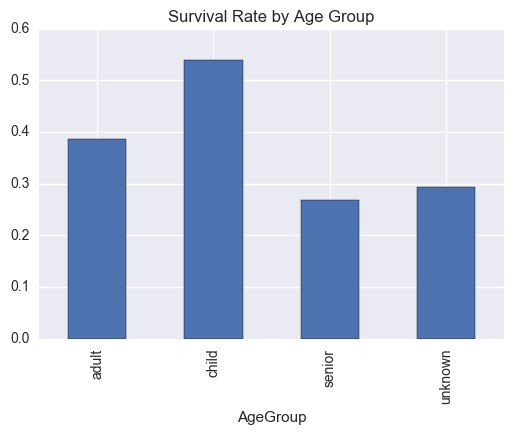

In [60]:
agegroup_survival = titanic_df.groupby('AgeGroup')['Survived']
print 'Survival rate by age group: ', agegroup_survival.describe()

agegroup_survival.mean().plot(kind='bar')
plt.title('Survival Rate by Age Group')

When broken down by age group, adults had a 38.61% survival rate, children had 53.98%, and seniors over 60 years old had a 26.92% survival rate.

In [73]:
## Independent t-test to compare survival means among age groups

child = titanic_df.loc[titanic_df['AgeGroup'] == 'child']['Survived']
adult = titanic_df.loc[titanic_df['AgeGroup'] == 'adult']['Survived']
senior = titanic_df.loc[titanic_df['AgeGroup'] == 'senior']['Survived']

## Child vs. Adult
t_test = stats.ttest_ind(child, adult)
print "child vs. adult t: %f, p: %f" %t_test

## Adult vs. Senior
t_test = stats.ttest_ind(senior, adult)
print "adult vs. senior t: %f, p: %f" %t_test

## Child vs. Senior
t_test = stats.ttest_ind(child, senior)
print "child vs. senior t: %f, p: %f" %t_test

## Proportion Chi-Squared test to compare survival rate among age groups

prop_test = stats.chi2_contingency(([child.sum(), adult.sum(), senior.sum()], 
                                    [child.count(), adult.count(), senior.count()]))
print "X^2: %f, p: %f" %prop_test[:2]

# Child vs. Adult + Senior

prop_test = stats.chi2_contingency(([child.sum(), adult.sum() + senior.sum()], 
                                    [child.count(), adult.count() + senior.count()]))
print "child vs. adult + senior X^2: %f, p: %f" %prop_test[:2]

child vs. adult t: 3.052244, p: 0.002359
adult vs. senior t: -1.199548, p: 0.230789
child vs. senior t: 2.527641, p: 0.012619
X^2: 4.585163, p: 0.101005
child vs. adult + senior X^2: 3.549485, p: 0.059564


Again using an alpha level of 0.05 and a t-test, children were significantly more likely to survive than either adults or seniors. However, there was no significant difference between adult and senior survival rates. However, the chi-squared test does not show a significant difference.

In [62]:
## Similarly, add a column for whether the passenger was traveling alone

titanic_df['Alone'] = (titanic_df['SibSp'] == 0) & (titanic_df['Parch'] == 0)
print titanic_df.iloc[:20][['SibSp', 'Parch', 'Alone']]    ## make sure it worked

             SibSp  Parch  Alone
PassengerId                     
1                1      0  False
2                1      0  False
3                0      0   True
4                1      0  False
5                0      0   True
6                0      0   True
7                0      0   True
8                3      1  False
9                0      2  False
10               1      0  False
11               1      1  False
12               0      0   True
13               0      0   True
14               1      5  False
15               0      0   True
16               0      0   True
17               4      1  False
18               0      0   True
19               1      0  False
20               0      0   True


Survival rate by whether passenger traveled alone:  Alone
False    0.505650
True     0.303538
Name: Survived, dtype: float64


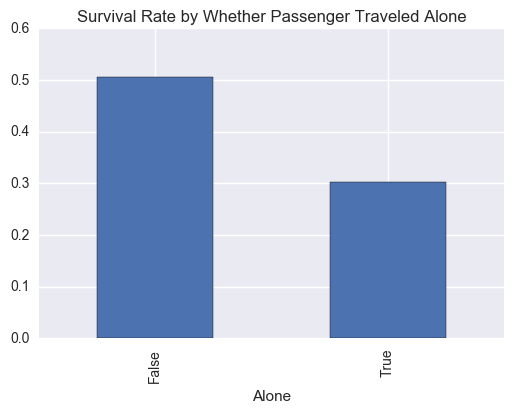

In [63]:
alone_survival = titanic_df.groupby('Alone')['Survived']
print 'Survival rate by whether passenger traveled alone: ', alone_survival.mean()

alone_survival.mean().plot(kind='bar')
plt.title('Survival Rate by Whether Passenger Traveled Alone')

Passengers traveling with family had a 50.57% survival rate, and passengers traveling alone had a 30.35% survival rate.

In [74]:
## Independent t-test to compate survival means between passengers traveling alone and with family

alone = titanic_df.loc[titanic_df['Alone'] == True]['Survived']
not_alone = titanic_df.loc[titanic_df['Alone'] == False]['Survived']

t_test = stats.ttest_ind(alone, not_alone)
print "t: %f, p: %f" %t_test

## Proportion Chi-Squared test to compare survival rate between passengers traveling alone and with family

prop_test = stats.chi2_contingency(([alone.sum(), not_alone.sum()], 
                                    [alone.count(), not_alone.count()]))
print "X^2: %f, p: %f" %prop_test[:2]

t: -6.193032, p: 0.000000
X^2: 15.499619, p: 0.000083


At alpha = 0.05, passengers traveling alone were significantly less likely to survive than those traveling with family

I'm also interested in what determined the price of the tickets. I would certainly predict that 1st class tickets would be more expensive than 2nd, which would be more expensive than 3rd, but that is clearly not the whole story.

Distribution of fare for each class:  Pclass       
1       count    216.000000
        mean      84.154687
        std       78.380373
        min        0.000000
        25%       30.923950
        50%       60.287500
        75%       93.500000
        max      512.329200
2       count    184.000000
        mean      20.662183
        std       13.417399
        min        0.000000
        25%       13.000000
        50%       14.250000
        75%       26.000000
        max       73.500000
3       count    491.000000
        mean      13.675550
        std       11.778142
        min        0.000000
        25%        7.750000
        50%        8.050000
        75%       15.500000
        max       69.550000
Name: Fare, dtype: float64


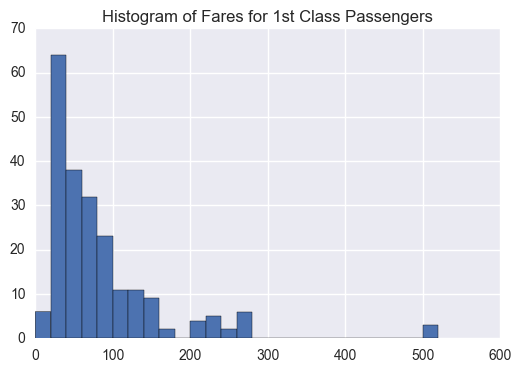

In [65]:
class_fare = titanic_df.groupby('Pclass')['Fare']
print 'Distribution of fare for each class: ', class_fare.describe()


plt.hist(titanic_df.loc[titanic_df['Pclass'] == 1]['Fare'], bins=26, range=(0,520))
plt.title('Histogram of Fares for 1st Class Passengers')

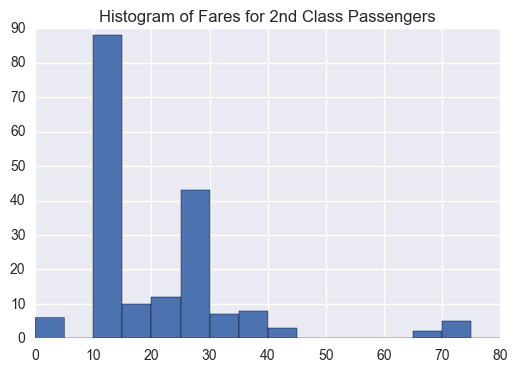

In [66]:
plt.hist(titanic_df.loc[titanic_df['Pclass'] == 2]['Fare'], bins=16, range=(0,80))
plt.title('Histogram of Fares for 2nd Class Passengers')

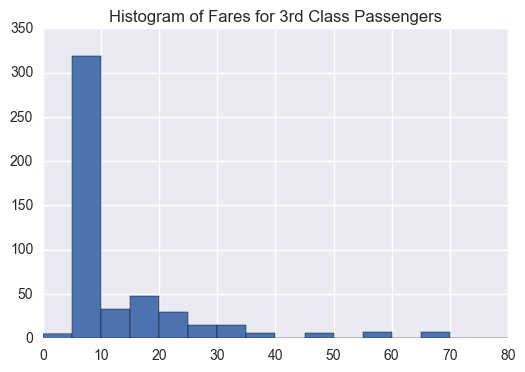

In [67]:
plt.hist(titanic_df.loc[titanic_df['Pclass'] == 3]['Fare'], bins=16, range=(0,80))
plt.title('Histogram of Fares for 3rd Class Passengers')

There is clearly a large variation of fares, and there is a large amount of overlap between the classes in fare prices.  Although class seems to be somewhat related to the price, there are clearly other factors at play. It is likely that these are factors not included in this dataset, such as when and how the ticket was purchased.

It's interesting that in each class there are passengers who paid nothing for their ticket. I'm wondering if this is actually the case or whether the 0.0 values are simply missing information.

In [68]:
print titanic_df.loc[titanic_df['Fare'] == 0.0]

             Survived  Pclass                              Name   Sex   Age  \
PassengerId                                                                   
180                 0       3               Leonard, Mr. Lionel  male  36.0   
264                 0       1             Harrison, Mr. William  male  40.0   
272                 1       3      Tornquist, Mr. William Henry  male  25.0   
278                 0       2       Parkes, Mr. Francis "Frank"  male   NaN   
303                 0       3   Johnson, Mr. William Cahoone Jr  male  19.0   
414                 0       2    Cunningham, Mr. Alfred Fleming  male   NaN   
467                 0       2             Campbell, Mr. William  male   NaN   
482                 0       2  Frost, Mr. Anthony Wood "Archie"  male   NaN   
598                 0       3               Johnson, Mr. Alfred  male  49.0   
634                 0       1     Parr, Mr. William Henry Marsh  male   NaN   
675                 0       2        Watson, Mr. Enn

Looking at these passengers who paid 0.0 for their ticket, there doesn't appear to be an immediate explanation for why this was the case. They are all males traveling alone, embarked from Southampton, and all but one died in the sinking. The ticket numbers are also more limited than the rest of the data, with all but one taking the form of LINE, 11205\_, or 23985\_. All of these factors makes me think that possibly these men were contracted to work on the ship in exchange for a free ticket. However, this is purely speculation. 

I'm going to keep them in the dataset, as it doesn't seem to be simply missing data in the 'Fare' column.

In [69]:
# print titanic_df.groupby('Port')['Fare', 'Pclass'].describe()

print titanic_df.groupby(['Pclass', 'Port'], as_index=False)['Fare'].describe()

                    count        mean        std      min      25%      50%  \
Pclass Port                                                                   
1      Cherbourg     85.0  104.718529  99.093935  26.5500  49.5000  78.2667   
       Queenstown     2.0   90.000000   0.000000  90.0000  90.0000  90.0000   
       Southampton  127.0   70.364862  58.811278   0.0000  29.2500  52.0000   
       Unknown        2.0   80.000000   0.000000  80.0000  80.0000  80.0000   
2      Cherbourg     17.0   25.358335  11.345067  12.0000  13.8625  24.0000   
       Queenstown     3.0   12.350000   0.000000  12.3500  12.3500  12.3500   
       Southampton  164.0   20.327439  13.630741   0.0000  13.0000  13.5000   
3      Cherbourg     66.0   11.214083   4.871528   4.0125   7.2292   7.8958   
       Queenstown    72.0   11.183393   6.721677   6.7500   7.7500   7.7500   
       Southampton  353.0   14.644083  13.276609   0.0000   7.8542   8.0500   

                           75%       max  
Pclass P

Looking at these descriptive statistics for the fares grouped by class and embarkation site, there doesn't appear to be any pattern that would suggest that the embarkation site affected the fares. There is no consistency in which site had the cheapest or most expensive fares, by any metric. Based on this, it doesn't look like this is worth investigating further. 

Unfortunately, I was not able to give a very satisfactory answer to the question about the fares with this data. I can say that class appears to be a factor, but not the only one, and that embarkation site does not appear to be a factor.

Conclusions

I was able to investigate each of my original questions:

* What were the rates of survival for 
  * men vs. women?
  * among the three classes?
  * children vs. adults?
  * people traveling alone vs. with family?
* How were the fares determined?

For the survival rate questions, the data reflected my expectations. Women were significantly more likely to survive than men, and there were significant differences in survival rate betweent the three classes, with first class passengers most likely to survive, and third class passengers the least. Children were significantly more likely to survive than adults. There was not a significant difference between adults' and seniors' survival rates, but the senior group was fairly small (n=26) and there were many passengers without age data, so these results are more tentative. Finally, passengers traveling alone were significantly less likely to survive than those traveling with family. These results are all correlational, and these are not conclusions about what caused certain passengers to survive. 

Looking at the fares, I wasn't able to determine much with this dataset. Clearly the class is some part of what determines the fare, but I would need more information to larnt he complete picture. The embarkation port does not appear to be a factor, so I did not do any statistical tests to investigate this further. I would need more information, such as when and how the ticket was purchased, to continue this line of investigation. It would also be interesting to know more information on the passengers who paid 0 fare, particularly whether they were employed on the ship in any capacity, as the data may suggest.

Sources: I used the pandas and matplotlib documentations for reference, as well as this site: http://iaingallagher.tumblr.com/post/50980987285/t-tests-in-python